# 2D Isostatic gravity inversion - Figures

Este [IPython Notebook](http://ipython.org/videos.html#the-ipython-notebook) utiliza a biblioteca de código aberto [Fatiando a Terra](http://fatiando.org/)

In [1]:
%matplotlib inline
import numpy as np
from scipy.misc import derivative
import scipy as spy
from scipy import interpolate
import matplotlib
#matplotlib.use('TkAgg', force=True)
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import math
import cPickle as pickle
import datetime
import string as st

from scipy.misc import imread

from __future__ import division

from fatiando import gravmag, mesher, utils, gridder
from fatiando.mesher import Prism, Polygon
from fatiando.gravmag import prism
from fatiando.utils import ang2vec, si2nt, contaminate
from fatiando.gridder import regular, profile
from fatiando.vis import mpl

from numpy.testing import assert_almost_equal
from numpy.testing import assert_array_almost_equal
from pytest import raises

plt.rc('font', size=16)

/Users/macelabastos/anaconda2/lib/python2.7/site-packages/fatiando/vis/mpl.py:76: UserWarning: This module will be removed in v0.6. We recommend the use of matplotlib.pyplot module directly. Some of the fatiando specific functions will remain.
  "specific functions will remain.")


In [2]:
import functions as fc

## Observation coordinates.

In [3]:
# Model`s limits
ymin = 0.0
ymax = 383000.0
zmin = -1000.0
zmax = 45000.0
xmin = -100000.0
xmax = 100000.0

area = [ymin, ymax, zmax, zmin]

In [4]:
ny = 150 # number of observation datas and number of prisms along the profile
# coordinates defining the horizontal boundaries of the
# adjacent columns along the profile
y = np.linspace(ymin, ymax, ny)

In [5]:
# coordinates of the center of the columns forming the
# interpretation model
n = ny - 1
dy = (ymax - ymin)/n
ycmin = ymin + 0.5*dy
ycmax = ymax - 0.5*dy
yc = np.reshape(np.linspace(ycmin, ycmax, n),(n,1))
x = np.zeros_like(yc)
z = np.zeros_like(yc)-150.0

In [6]:
## Edge extension (observation coordinates)
sigma = 2.0
edge = sigma*dy*n

## Model parameters

In [7]:
# Model densities
# Indices and polygons relationship:
# cc = continental crust layer
# oc = ocean crust layer
# w = water layer
# s = sediment layer
# m = mantle layer
dw = np.array([1030.0])
ds0 = np.array([2350.0])
ds1 = np.array([2855.0])
dcc = np.array([2870.0])
doc = np.array([2885.0])
dm = np.array([3240.0])
#dc = dcc
# coordinate defining the horizontal boundaries of the continent-ocean boundary
COT = 350000.0
# list defining crust density variance
dc = np.zeros_like(yc)
aux = yc <= COT
for i in range(len(yc[aux])):
    dc[i] = dcc
for i in range(len(yc[aux]),n):
    dc[i] = doc    
# defining sediments layers density matrix
ds = np.vstack((np.reshape(np.repeat(ds0,n),(1,n)),np.reshape(np.repeat(ds1,n),(1,n))))

# S0 => isostatic compensation surface (Airy's model)
# SR = S0+dS0 => reference Moho (Forward modeling)
S0 = np.array([41000.0])

## Observed data

In [8]:
gobs = np.reshape(np.loadtxt('../data/pelotas-profile-gz.txt'),(n,1))

## Water bottom

In [9]:
bathymetry = np.reshape(np.loadtxt('../data/etopo1-pelotas.txt'),(n,1))
tw = 0.0 - bathymetry

## Interpreted surfaces

In [10]:
toi = np.reshape(np.loadtxt('../data/pelotas-profile-interpreted-toi-surface.txt'),(n,1))

interpreted_basement = np.reshape(np.loadtxt('../data/pelotas-profile-interpreted-basement-surface.txt'),(n,1))

interpreted_moho = np.reshape(np.loadtxt('../data/pelotas-profile-interpreted-moho-surface.txt'),(n,1))

# reference moho surface (SR = S0+dS0)
dS0 = np.array([2200.0])

In [11]:
# 1st layer sediments thickness
ts0 = toi - tw
# 2nd layer sediments thickness
ts1 = interpreted_basement - toi
# thickness sediments vector
ts = np.vstack((np.reshape(ts0,(1,n)),np.reshape(ts1,(1,n))))
# layer mantle thickness
tm = S0 - interpreted_moho
# pelotas profile parameters vector
p_interp = np.vstack((ts1, tm, dS0))

## Initial guess surfaces

In [12]:
# initial guess basement surface
ini_basement = np.reshape(np.loadtxt('../data/pelotas-profile-initial-basement-surface.txt'),(n,1))

# initial guess moho surface
ini_moho = np.reshape(np.loadtxt('../data/pelotas-profile-initial-moho-surface.txt'),(n,1))

# initial guess reference moho surface (SR = S0+dS0)
ini_dS0 = np.array([1000.0])
ini_RM = S0 + ini_dS0

## Known depths

In [13]:
# Known values: basement and moho surfaces

base_known = np.loadtxt('../data/pelotas-profile-basement-known-depths.txt')
#base_known = np.loadtxt('../data/pelotas-profile-basement-more-known-depths.txt')
#base_known_new = np.loadtxt('../data/pelotas-profile-basement-new-known-depths.txt')
#base_known = np.loadtxt('../data/pelotas-profile-basement-few-more-known-depths.txt')
#base_known_new = np.loadtxt('../data/pelotas-profile-basement-few-new-known-depths.txt')
#base_known_old = np.loadtxt('../data/pelotas-profile-basement-known-depths.txt')

moho_known = np.loadtxt('../data/pelotas-profile-moho-known-depths.txt')

## Initial guess data

In [14]:
g0 = np.reshape(np.loadtxt('../data/pelotas-profile-initial-guess-gravity-data.txt'),(n,1))

## Inversion model

In [15]:
p = np.reshape(np.loadtxt('../data/pelotas-profile-parameter-vector-alphas_-10(2)_-8(1)_-7(1)_-6(2).txt'),(2*n+1,1))
g = np.reshape(np.loadtxt('../data/pelotas-profile-predicted-gravity-data-alphas_-10(2)_-8(1)_-7(1)_-6(2).txt'),(n,1))
#gama_list = np.loadtxt('../data/pelotas-profile-gama-list-alphas_-10(2)_-8(1)_-7(1)_-6(2).txt')

In [16]:
g0 = g.copy()
ini_basement = tw + ts0 + p[0:n]
ini_moho = S0 - p[n:n+n]

In [17]:
p = np.reshape(np.loadtxt('../data/pelotas-profile-parameter-vector-alphas_-10(2)_-8(1)_-7(1)_-6(2)-sgm_70.txt'),(2*n+1,1))
g = np.reshape(np.loadtxt('../data/pelotas-profile-predicted-gravity-data-alphas_-10(2)_-8(1)_-7(1)_-6(2)-sgm_70.txt'),(n,1))
#gama_list = np.loadtxt('../data/pelotas-profile-gama-list-alphas_-10(2)_-8(1)_-7(1)_-6(2)-sgm_58.txt')

In [18]:
# Inverrsion results
RM = S0 + p[n+n]
basement = tw + ts0 + p[0:n]
moho = S0 - p[n:n+n]

## Lithostatic Stress

In [19]:
sgm_interp = 9.81*(10**(-6))*(dw*tw + ds0*ts0 + ds1*ts1 + dc*(S0-tw-ts0-ts1-tm)+dm*tm)

sgm = 9.81*(10**(-6))*(dw*tw + ds0*ts0 + ds1*p[0:n] + dc*(S0-tw-ts0-p[0:n]-p[n:n+n])+dm*p[n:n+n])

## Inversion model plot

In [20]:
polygons_water = []
for (yi, twi) in zip(yc, tw):
    y1 = yi - 0.5*dy
    y2 = yi + 0.5*dy

    polygons_water.append(Polygon(np.array([[y1, y2, y2, y1], 
                                            [0.0, 0.0, twi, twi]]).T,
                                               props={'density': dw - dcc}))
polygons_sediments0 = []
for (yi, twi, s0i) in zip(yc, np.reshape(tw,(n,)), np.reshape(toi,(n,))):
    y1 = yi - 0.5*dy
    y2 = yi + 0.5*dy

    polygons_sediments0.append(Polygon(np.array([[y1, y2, y2, y1], 
                                                [twi, twi, s0i, s0i]]).T,
                                                    props={'density': ds0 - dcc}))
    
polygons_sediments1 = []
for (yi, s0i, s1i) in zip(yc, np.reshape(toi,(n,)), np.reshape(basement,(n,))):
    y1 = yi - 0.5*dy
    y2 = yi + 0.5*dy

    polygons_sediments1.append(Polygon(np.array([[y1, y2, y2, y1], 
                                                [s0i, s0i, s1i, s1i]]).T,
                                                   props={'density': ds1 - dcc}))
    
polygons_crust = []
for (yi, si, Si, dci) in zip(yc, np.reshape(basement,(n,)), np.reshape(moho,(n,)), dc):
    y1 = yi - 0.5*dy
    y2 = yi + 0.5*dy

    polygons_crust.append(Polygon(np.array([[y1, y2, y2, y1], 
                                            [si, si, Si, Si]]).T,
                                                props={'density': dci - dcc})) 

polygons_mantle = []
for (yi, Si) in zip(yc, np.reshape(moho,(n,))):
    y1 = yi - 0.5*dy
    y2 = yi + 0.5*dy

    polygons_mantle.append(Polygon(np.array([[y1, y2, y2, y1], 
                                                [Si, Si, (S0+p[n+n]), (S0+p[n+n])]]).T,
                                                    props={'density': dm - dcc}))

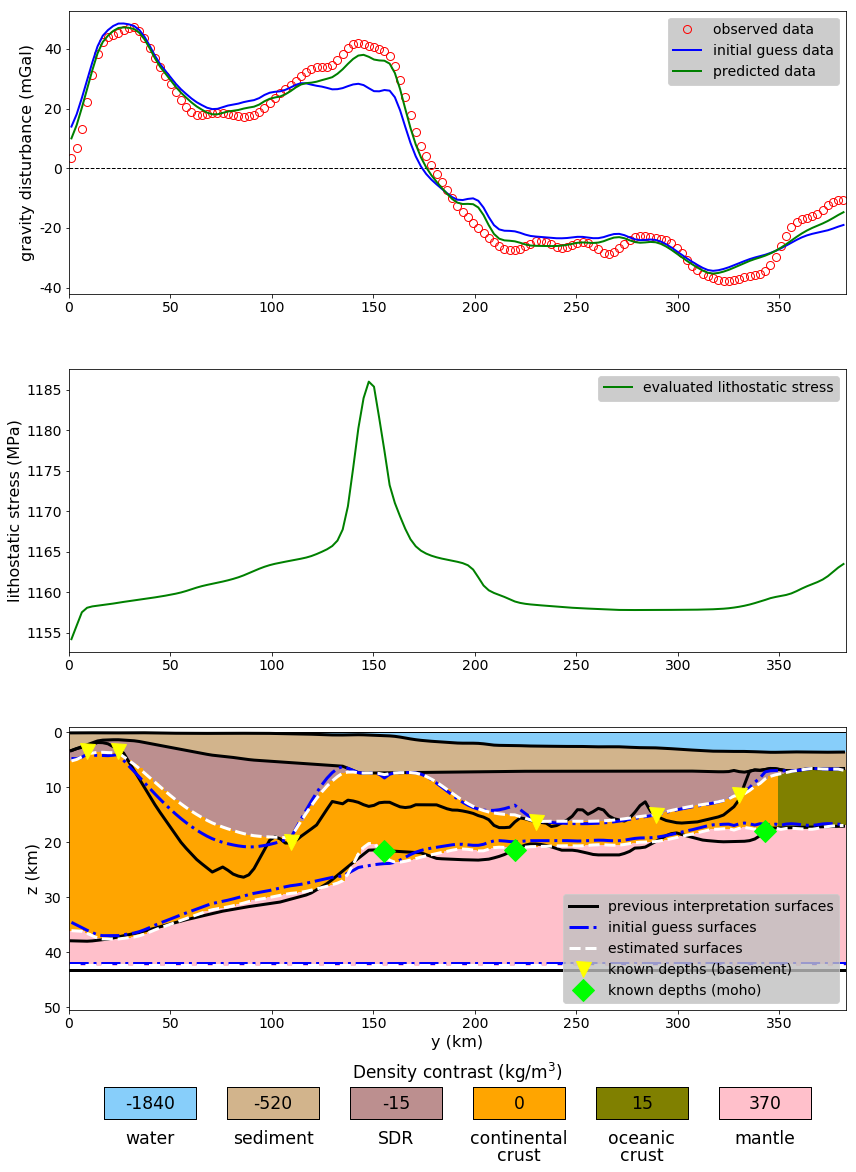

In [21]:
%matplotlib inline
plt.close('all')
fig = plt.figure(figsize=(12,16))

import matplotlib.gridspec as gridspec
heights = [8, 8, 8, 1]
gs = gridspec.GridSpec(4, 1, height_ratios=heights)
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[2])
ax4 = plt.subplot(gs[3])

ax1.axhline(y=0.0, xmin=ymin, xmax=ymax, color='k', linestyle='--', linewidth=1)
ax1.plot(0.001*yc, gobs, 'or', mfc='none', markersize=8, label='observed data')
ax1.plot(0.001*yc, g0, '-b', linewidth=2, label='initial guess data')
ax1.plot(0.001*yc, g, '-g', linewidth=2, label='predicted data')
ax1.set_xlim(0.001*ymin, 0.001*ymax)
ax1.set_ylabel('gravity disturbance (mGal)', fontsize=16)
ax1.set_xticklabels(['%g'% (l) for l in ax1.get_xticks()], fontsize=14)
ax1.set_yticklabels(['%g'% (l) for l in ax1.get_yticks()], fontsize=14)
ax1.legend(loc='best', fontsize=14, facecolor='silver')

#ax2.plot(0.001*yc, sgm_interp, 'or', mfc='none', markersize=8, label='preliminary interpretation lithostatic stress')
ax2.plot(0.001*yc, sgm, '-g', linewidth=2, label='evaluated lithostatic stress')
ax2.set_xlim(0.001*ymin, 0.001*ymax)
#ax2.set_ylim(752.,812.)
ax2.set_ylabel('lithostatic stress (MPa)', fontsize=16)
ax2.set_xticklabels(['%g'% (l) for l in ax2.get_xticks()], fontsize=14)
ax2.set_yticklabels(['%g'% (l) for l in ax2.get_yticks()], fontsize=14)
ax2.legend(loc='best', fontsize=14, facecolor='silver')

ax3.axhline(y=0.0, xmin=ymin, xmax=ymax, color='k', linestyle='-', linewidth=1)
aux = yc <= COT
for (pwi) in (polygons_water):
    tmpx = [x for x in pwi.x]
    tmpx.append(pwi.x[0])
    tmpy = [y for y in pwi.y]
    tmpy.append(pwi.y[0])
    ax3.plot(tmpx, tmpy, linestyle='None')
    ax3.fill(tmpx, tmpy, color='lightskyblue')
for (ps0i) in (polygons_sediments0):
    tmpx = [x for x in ps0i.x]
    tmpx.append(ps0i.x[0])
    tmpy = [y for y in ps0i.y]
    tmpy.append(ps0i.y[0])
    ax3.plot(tmpx, tmpy, linestyle='None')
    ax3.fill(tmpx, tmpy, color='tan')
for (ps1i) in (polygons_sediments1):
    tmpx = [x for x in ps1i.x]
    tmpx.append(ps1i.x[0])
    tmpy = [y for y in ps1i.y]
    tmpy.append(ps1i.y[0])
    ax3.plot(tmpx, tmpy, linestyle='None')
    ax3.fill(tmpx, tmpy, color='rosybrown')
for (pci) in (polygons_crust[:len(yc[aux])]):
    tmpx = [x for x in pci.x]
    tmpx.append(pci.x[0])
    tmpy = [y for y in pci.y]
    tmpy.append(pci.y[0])
    ax3.plot(tmpx, tmpy, linestyle='None')
    ax3.fill(tmpx, tmpy, color='orange')
for (pcoi) in (polygons_crust[len(yc[aux]):n]):
    tmpx = [x for x in pcoi.x]
    tmpx.append(pcoi.x[0])
    tmpy = [y for y in pcoi.y]
    tmpy.append(pcoi.y[0])
    ax3.plot(tmpx, tmpy, linestyle='None')
    ax3.fill(tmpx, tmpy, color='olive')
for (pmi) in (polygons_mantle):
    tmpx = [x for x in pmi.x]
    tmpx.append(pmi.x[0])
    tmpy = [y for y in pmi.y]
    tmpy.append(pmi.y[0])
    ax3.plot(tmpx, tmpy, linestyle='None')
    ax3.fill(tmpx, tmpy, color='pink')

ax3.plot(yc, tw, '-k', linewidth=3)
ax3.plot(yc, toi, '-k', linewidth=3)
ax3.plot(yc, interpreted_basement, '-k', linewidth=3, label='previous interpretation surfaces')
ax3.plot(yc, interpreted_moho, '-k', linewidth=3)
ax3.plot(yc, ini_basement, '-.b', linewidth=3, label='initial guess surfaces')
ax3.plot(yc, ini_moho, '-.b', linewidth=3)
ax3.plot(yc, basement, '--w', linewidth=3, label='estimated surfaces')
ax3.plot(yc, moho, '--w', linewidth=3)
ax3.axhline(y=S0+dS0, xmin=ymin, xmax=ymax, color='k', linestyle='-', linewidth=3)
ax3.axhline(y=S0+ini_dS0, xmin=ymin, xmax=ymax, color='b', linestyle='-.', linewidth=3)
ax3.axhline(y=S0+p[n+n], xmin=ymin, xmax=ymax, color='w', linestyle='--', linewidth=3)
ax3.plot(base_known[:,0], base_known[:,1], 'v', color = 'yellow', markersize=15, label='known depths (basement)')
#ax3.plot(base_known_old[:,0], base_known_old[:,1], 'v', color = 'yellow', markersize=15, label='known depths (basement)')
#ax3.plot(base_known_new[:,0], base_known_new[:,1], 'v', color = 'magenta', markersize=15, label='more known depths (basement)')
ax3.plot(moho_known[:,0], moho_known[:,1], 'D', color = 'lime', markersize=15, label='known depths (moho)')
#ax3.set_ylim((S0+p[n+n]), zmin)
ax3.set_ylim((50500.0), zmin)
ax3.set_xlim(ymin, ymax)
ax3.set_xlabel('y (km)', fontsize=16)
ax3.set_ylabel('z (km)', fontsize=16)
ax3.set_xticklabels(['%g'% (0.001*l) for l in ax3.get_xticks()], fontsize=14)
ax3.set_yticklabels(['%g'% (0.001*l) for l in ax3.get_yticks()], fontsize=14)
ax3.legend(loc='lower right', fontsize=14, facecolor='silver')    

X, Y = fig.get_dpi()*fig.get_size_inches()
plt.title('Density contrast (kg/m$^{3}$)', fontsize=17)
ax4.axis('off')

layers_list1 = ['water', 'sediment', 'SDR', 'continental', 'oceanic', 'mantle']
layers_list2 = ['', '', '', 'crust', 'crust', '']
colors_list = ['lightskyblue', 'tan', 'rosybrown', 'orange', 'olive', 'pink']
density_list = ['-1840', '-520', '-15', '0', '15', '370']
ncols = len(colors_list)
nrows = 1
h = Y / nrows
w = X / (ncols + 1)

i=ncols-1
for color, density, layers1, layers2 in zip(colors_list, density_list, layers_list1, layers_list2):
    col = i // nrows
    row = i % nrows
    x = X - (col*w) - w
    
    yi_line = Y
    yf_line = Y - Y*0.15
    yi_text1 = Y - Y*0.2
    yi_text2 = Y - Y*0.28
    yi_text3 = Y - Y*0.08
    
    i-=1
    poly = Polygon(np.array([[x, x+w*0.75, x+w*0.75, x], [yi_line, yi_line, yf_line, yf_line]]).T)
    tmpx = [x for x in poly.x]
    tmpx.append(poly.x[0])
    tmpy = [y for y in poly.y]
    tmpy.append(poly.y[0])
    ax4.plot(tmpx, tmpy, linestyle='-', color='k', linewidth=1)
    ax4.fill(tmpx, tmpy, color=color)
    ax4.text(x+w*0.375, yi_text1, layers1, fontsize=(w*0.14), horizontalalignment='center', verticalalignment='top')
    ax4.text(x+w*0.375, yi_text2, layers2, fontsize=(w*0.14), horizontalalignment='center', verticalalignment='top')
    ax4.text(x+w*0.375, yi_text3, density, color = 'k', fontsize=(w*0.14), horizontalalignment='center', verticalalignment='center')

plt.tight_layout()    
    
#mpl.savefig('../manuscript/figures/pelotas-profile-grafics-estimated-model-alphas_X_1_1_2.png', dpi='figure', bbox_inches='tight')
#mpl.savefig('../manuscript/figures/pelotas-profile-grafics-estimated-model-alphas_2_1_1_2-sgm_70.png', dpi='figure', bbox_inches='tight')
#mpl.savefig('../manuscript/figures/pelotas-profile-grafics-estimated-model-alphas_2_1_1_2-sgm_58_more-known-depths.png', dpi='figure', bbox_inches='tight')
#mpl.savefig('../manuscript/figures/pelotas-profile-grafics-estimated-model-alphas_2_1_1_2_more-known-depths.png', dpi='figure', bbox_inches='tight')
plt.show()